In [1]:
from IPython.display import clear_output, display
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from flopy.utils.gridintersect import GridIntersect
import flopy
import pandas as pd

# Groundwater Modeling and Python Programming

In this exercise, we will use MODPATH to simulate advective transport with the Freyberg flow model. For this exercise, we will use a quadtree version of the Freyberg model.

The location of the contamination patch and the nodes that the define bounding cells of the patch are calculated below.

In [2]:
# patch upper left and lower right
xmin, xmax = 250. * 1, 250. * 3
ymin, ymax = (40 - 14) * 250., (40 - 11) * 250. 

csx, csy = [xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin]
polygon = [list(zip(csx, csy))]
(xmin, ymax), (xmax, ymin)

((250.0, 7250.0), (750.0, 6500.0))

--------------------------

### Define the workspace and model names.

In [3]:
load_ws = pl.Path('data/quadtree')
ws = pl.Path("temp/ex10a")
name = "project"
name_mp = f"{name}_mp"
exe_name = 'mf6'

## Load the MODFLOW 6 Model

Load a simulation object using `flopy.mf6.MFSimulation().load()`.

In [4]:
sim = flopy.mf6.MFSimulation.load(sim_name=name, exe_name=exe_name,
                                    sim_ws=load_ws)

loading simulation...
  loading simulation name file...


MFDataException: An error occurred in package "None". The error occurred while loading package file in the "load" method.
Additional Information:
(1) File /home/runner/work/python-for-hydrology/python-for-hydrology/docs/source/notebooks/part1_flopy/data/quadtree/mfsim.nam of type nam could not be opened.

### Load the groundwater flow model

In [5]:
gwf = sim.get_model(name)
gwf.modelgrid

NameError: name 'sim' is not defined

### Change the workspace

In [6]:
sim.set_sim_path(ws)

NameError: name 'sim' is not defined

### Write the model files

In [7]:
sim.write_simulation()

NameError: name 'sim' is not defined

Run the simulation.

In [8]:
sim.run_simulation()

NameError: name 'sim' is not defined

## Create and Run the MODPATH model


### Lets plot the model grid and the location of the contamination patch.

NameError: name 'gwf' is not defined

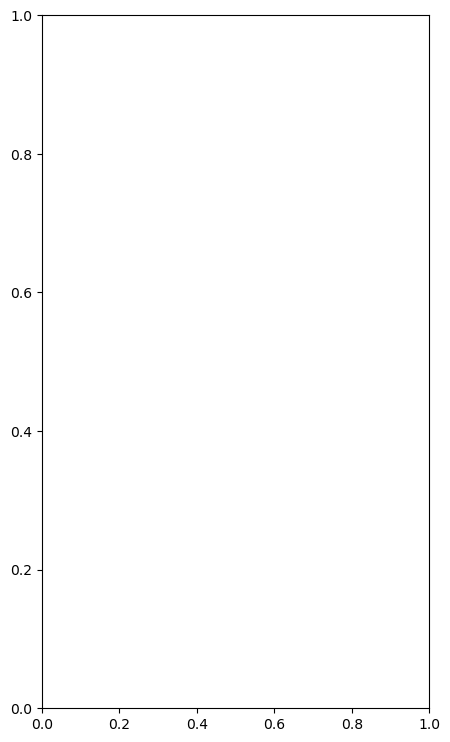

In [9]:
fig, ax = plt.subplots(figsize=(5, 9))
mm = flopy.plot.PlotMapView(gwf, layer=0, ax=ax)

mm.plot_bc('SFR', color="b", plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_inactive(alpha=0.75)

mm.plot_grid(lw=0.25, color='grey')

ax.fill(csx, csy, color='#e534eb');

Find the node numbers of the contamination patch using the groundwater model grid object and the `GridIntersect` utility. The `GridIntersect` utility has an `intersect` method that can be used to identified cellids from points, lines, and polygons.

In [10]:
gx = GridIntersect(gwf.modelgrid)
results = gx.intersect(polygon, 'Polygon')
nodes = results.cellids
nodes

NameError: name 'gwf' is not defined

### Create the MODPATH particle data

In [11]:
# create
sd = flopy.modpath.CellDataType()
p = flopy.modpath.NodeParticleData(subdivisiondata=[sd],
                                   nodes=list(nodes))
# create forward particle group
fpth = name_mp + '.sloc'
pg = flopy.modpath.ParticleGroupNodeTemplate(particlegroupname='contaminant',
                                             particledata=p,
                                             filename=fpth)

NameError: name 'nodes' is not defined

### Create the MODPATH 7 files

In [12]:
# create modpath files
mp = flopy.modpath.Modpath7(modelname=name_mp, flowmodel=gwf,
                            exe_name='mp7', model_ws=ws)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='pathline', 
                                  trackingdirection='forward',
                                  weaksinkoption='pass_through',
                                  weaksourceoption='pass_through',
                                  referencetime=0.,
                                  stoptimeoption='extend',
                                  particlegroups=pg)
help(flopy.modpath.Modpath7Sim)

NameError: name 'gwf' is not defined

### Write MODPATH 7 files and run the model

In [13]:
# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

NameError: name 'mp' is not defined

## Post-Process the MODFLOW and MODPATH Results


### Load MODFLOW and MODPATH results from the heads and pathline files

Load the MODFLOW heads

In [14]:
hobj = gwf.output.head()

NameError: name 'gwf' is not defined

In [15]:
hds = hobj.get_data()

NameError: name 'hobj' is not defined

Load the pathline file

In [16]:
ppth =ws / f"{name_mp}.mppth"
p = flopy.utils.PathlineFile(ppth)
p0 = p.get_alldata()

FileNotFoundError: [Errno 2] No such file or directory: '/home/runner/work/python-for-hydrology/python-for-hydrology/docs/source/notebooks/part1_flopy/temp/ex10a/project_mp.mppth'

In [17]:
p0

NameError: name 'p0' is not defined

### Plot the heads and pathlines

NameError: name 'gwf' is not defined

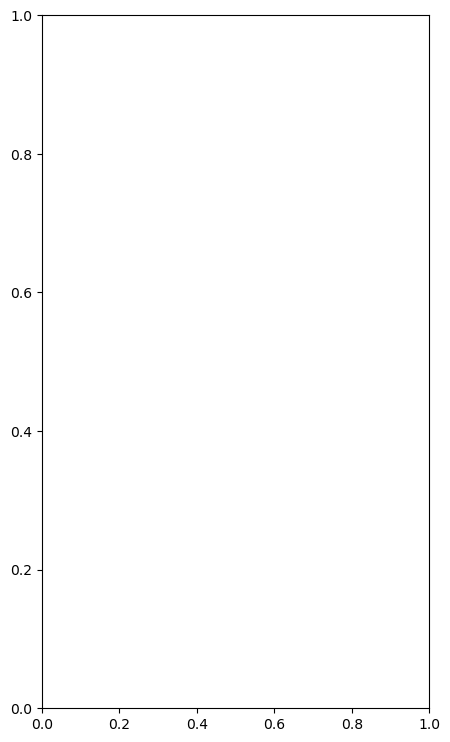

In [18]:
fig, ax = plt.subplots(figsize=(5, 9))
mm = flopy.plot.PlotMapView(model=gwf, layer=0, ax=ax)
mm.plot_array(hds, masked_values=[1e30])

mm.plot_bc('SFR', color='b', plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_ibound()
mm.plot_pathline(p0, layer='all', color='blue', lw=1)
mm.plot_grid(lw=0.2, color="0.5")

ax = plt.gca()
ax.fill(csx, csy, color='#e534eb', zorder=100, alpha=.75);

NameError: name 'gwf' is not defined

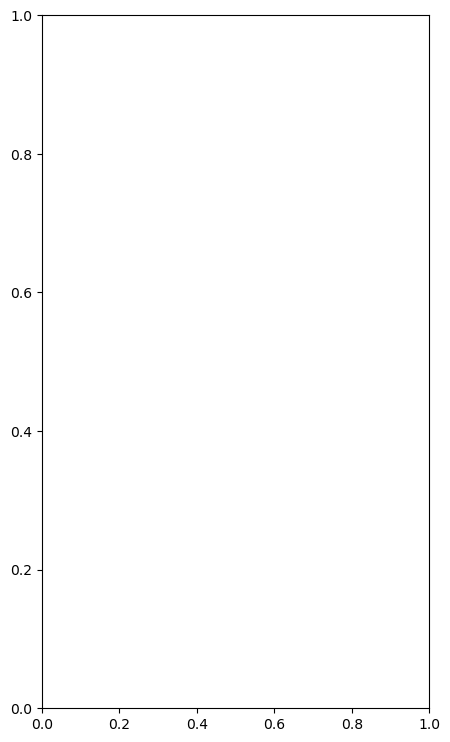

In [19]:
fig, ax = plt.subplots(figsize=(5, 9))

mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
mm.plot_array(hds, masked_values=[1e30])
mm.plot_bc('SFR', color='b', plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_ibound()
mm.plot_grid(lw=0.2, color="0.5")

p = flopy.utils.PathlineFile(ppth)
p0 = p.get_alldata()
df = pd.DataFrame.from_records(p0[0])
for ix, recarray in enumerate(p0):
    dft = pd.DataFrame.from_records(recarray)
    df = pd.concat((df, dft), ignore_index=True)
vmin, vmax = df.time.min(), df.time.max()

times = list(range(0, 74001, 1000))
for ix in range(1, len(times)):
    tmp = df[(df.time >= times[ix - 1]) & (df.time < times[ix])]
    s = ax.scatter(tmp.x.values, tmp.y.values, c=tmp.time.values, vmin=vmin, vmax=vmax, cmap="magma")
    ax.set_title(f"{times[ix - 1]} - {times[ix]} days")
    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)    

### Export the pathlines to a shapefile

In [20]:
spth = pl.Path(ws / 'pathline.shp')
p.write_shapefile(p0, mg=gwf.modelgrid, one_per_particle=False, shpname=spth)

NameError: name 'p' is not defined

### Load the shapefile into geopandas

In [21]:
rshp = gpd.read_file(spth)

DriverError: temp/ex10a/pathline.shp: No such file or directory

### Show the dataframe

In [22]:
rshp

NameError: name 'rshp' is not defined

### Plot the geopandas dataframe on the modelgrid

NameError: name 'gwf' is not defined

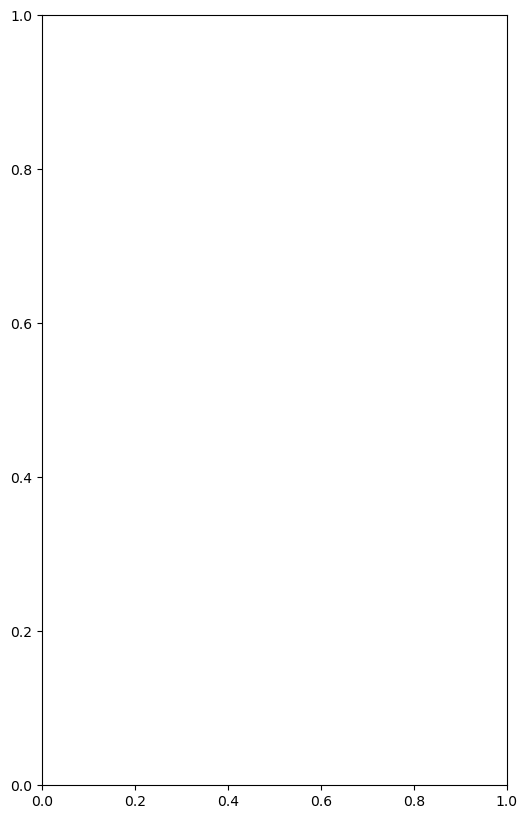

In [23]:
fig, ax = plt.subplots(figsize=(6, 10))
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pmv.plot_grid(lw=0.5)
pmv.plot_shapes(rshp.geometry.to_list(), edgecolor="grey") #, edgecolor="b")
pmv.plot_ibound();

## Export the data to VTK (Visualization ToolKit) format for a 3d representation

FloPy's `Vtk` module allows us to create Visualization ToolKit (VTK) files that can be opened and explored with pyVISTAs or external software such as ParaView.

In [24]:
from flopy.export.vtk import Vtk

vtk = Vtk(model=gwf, binary=False, vertical_exageration=50, smooth=False)
vtk.add_model(gwf)
vtk.add_pathline_points(p0)

NameError: name 'gwf' is not defined

Write VTK file for use in ParaView or other VTK software

In [25]:
pth = pl.Path("temp")
pth.mkdir(exist_ok=True)

vtk.write(pth)

NameError: name 'vtk' is not defined

## Alternatively we can visualize the VTK representation using `pyvista`

In [26]:
import pyvista as pv

ModuleNotFoundError: No module named 'pyvista'

Convert the VTK to pyvista meshes and rotate the meshes to match the orientation of our matplotlib plots

In [27]:
grid, pathlines = vtk.to_pyvista()

NameError: name 'vtk' is not defined

In [28]:
axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)

grid.rotate_z(160, point=axes.origin, inplace=True)
pathlines.rotate_z(160, point=axes.origin, inplace=True)

NameError: name 'pv' is not defined

Select particle release locations and build a dictionary of particle tracks (pathlines). This will be used below for particle labelling, as well as for animation.

*Note*: while below we construct pathlines manually from data read from the exported VTK files, pathlines may also be read directly from the MODPATH 7 pathline output file (provided the simulation was run in pathline or combined mode, as this one was).

In [29]:
tracks = {}
particle_ids = set()
release_locs = list()

for i, t in enumerate(pathlines["time"]):
    pid = str(round(float(pathlines["particleid"][i])))
    loc = pathlines.points[i]

    if pid not in tracks:
        tracks[pid] = []
        particle_ids.add(pid)
        release_locs.append(loc)

    # store the particle location in the corresponding track
    tracks[pid].append((loc, t))

release_locs = np.array(release_locs)
tracks = {k: np.array(v, dtype=object) for k, v in tracks.items()}
max_track_len = max([len(v) for v in tracks.values()])

NameError: name 'pathlines' is not defined

View the grid and pathlines with PyVista, with particle tracks/locations colored by time. Also add particle ID labels to a few particles’ release locations.

In [30]:
pv.set_plot_theme("document")
pv.set_jupyter_backend("static")

# create the plot and add the grid and pathline meshes
p = pv.Plotter()
p.add_mesh(grid, opacity=0.05)
p.add_mesh(pathlines, scalars="time")

# add a particle ID label to each 20th particle's starting point
label_coords = []
start_labels = []
for pid, track in tracks.items():
    if int(pid) % 20 == 0:
        label_coords.append(track[0][0])
        start_labels.append(f"Particle {pid}")

p.add_point_labels(
    label_coords,
    start_labels,
    font_size=10,
    point_size=15,
    point_color="black",
)

# zoom in and show the plot
p.camera.zoom(2.4)
p.show()

NameError: name 'pv' is not defined

Create an animated GIF of the particles traveling along their pathlines, with particles colored by time.

In [31]:
# create plotter
p = pv.Plotter(notebook=False, off_screen=True)

# open GIF file
gif_path = pth / f"freyberg_tracks.gif"
p.open_gif(str(gif_path))

# create mesh from release locations
spls = pv.PolyData(release_locs)
spls.point_data["time"] = np.zeros(len(spls.points))

# add the underlying grid mesh and particle data, then zoom in
p.add_mesh(grid, opacity=0.05)
p.add_mesh(spls, clim=[0, 1.23e09])
p.camera.zoom(2.4)

# cycle through time steps and update particle location
for i in range(1, max_track_len):
    pts = []
    times = []
    segments = []

    for pid in particle_ids:
        track = tracks[pid]
        npts = len(track)
        # use last locn if particle has already terminated
        loc, t = track[i] if i < npts else track[npts - 1]
        pts.append(loc)
        times.append(t)
        if i < npts:
            segments.append(track[i - 1][0])
            segments.append(loc)

    p.update_coordinates(np.vstack(pts), render=False)
    p.update_scalars(np.array(times), mesh=spls, render=False)
    p.add_lines(np.array(segments), width=1, color="black")
    p.write_frame()  # write frame to file

# close the plotter and the GIF file
p.close()

NameError: name 'pv' is not defined

In [32]:
from IPython.core.display import Image

display(Image(data=open(gif_path, "rb").read(), format="gif"))

NameError: name 'gif_path' is not defined